In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd

# 📘 BAB 1: Data Preparation



##1.1 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/dataset/eye-diseases'


##1.2 Membuat Tabel Data Gambar dan Label

Setiap gambar akan dibaca dan disimpan ke dalam DataFrame berisi:
- Path lengkap file
- Label klasifikasi: `cataract` atau `normal`


In [ ]:
data = []

for label in ['cataract', 'normal']:
    folder_path = os.path.join(base_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            data.append({
                'filepath': os.path.join(folder_path, filename),
                'label': label
            })

df = pd.DataFrame(data)
df.head()


,filepath,label
0,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract
1,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract
2,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract
3,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract
4,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract


In [ ]:
df.tail(3)

,filepath,label
2109,/content/drive/MyDrive/dataset/eye-diseases/no...,normal
2110,/content/drive/MyDrive/dataset/eye-diseases/no...,normal
2111,/content/drive/MyDrive/dataset/eye-diseases/no...,normal


# 📗 BAB 2: Exploratory Data Analysis (EDA)



##2.1 Jumlah Data per Label

Kita akan melihat distribusi jumlah gambar untuk setiap kelas (`cataract` dan `normal`) agar tahu apakah datanya seimbang atau tidak.

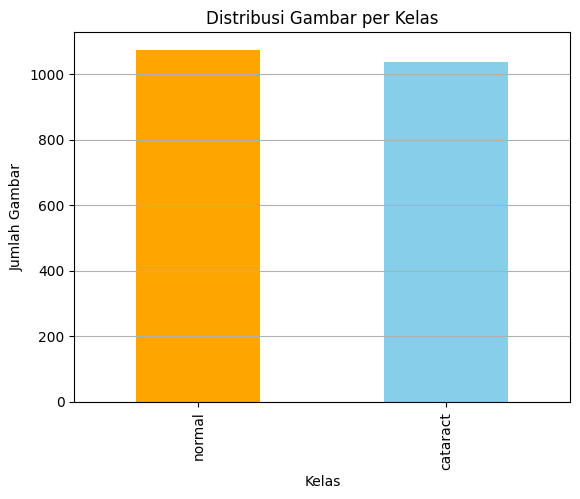

In [ ]:


df['label'].value_counts().plot(kind='bar', color=['orange', 'skyblue'])
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y')
plt.show()


## 2.2 Contoh Gambar dari Dataset

Di bawah ini ditampilkan beberapa contoh gambar dari kedua label. Hal ini penting untuk melihat apakah mata katarak dan normal bisa dibedakan secara visual.


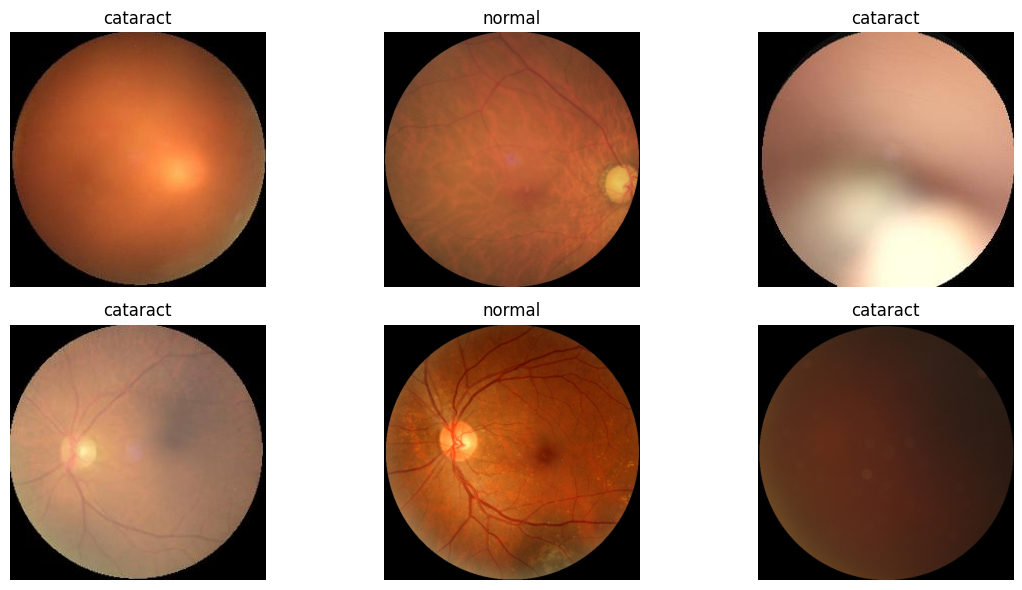

In [ ]:
sample = df.sample(6, random_state=1)

plt.figure(figsize=(12, 6))

for i, row in enumerate(sample.itertuples()):
    img = cv2.imread(row.filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')

plt.tight_layout()
plt.show()


## 2.3 Cek Data Duplikat


In [ ]:
# Cek duplikat
print("Duplikat:", df.duplicated().sum())

# Cek apakah semua file benar-benar ada
import os
missing = df[~df['filepath'].apply(os.path.exists)]
print("File hilang:", len(missing))


Duplikat: 0
File hilang: 0


## 2.4 Data Manipulasi (Label Encoding)


In [ ]:
df['label_num'] = df['label'].map({'normal': 0, 'cataract': 1})
df.head()

,filepath,label,label_num
0,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract,1
1,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract,1
2,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract,1
3,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract,1
4,/content/drive/MyDrive/dataset/eye-diseases/ca...,cataract,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepath   2112 non-null   object
 1   label      2112 non-null   object
 2   label_num  2112 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.6+ KB


## 📊 2.5 Insight dari Dataset

###Dataset Secara Umum
- Jumlah gambar **seimbang** antara kelas `cataract` dan `normal`.
- Tidak ditemukan file yang **rusak** atau **duplikat** setelah pengecekan awal.

###Insight dari Visualisasi Gambar
- Gambar **cataract** cenderung **buram**, dengan warna pudar, dan sulit terlihat struktur retina seperti makula atau pembuluh darah.
- Gambar **normal** lebih **tajam**, memiliki kontras tinggi, dan terlihat jelas pembuluh darah dan bagian optik retina.
- Perbedaan visual ini dapat dimanfaatkan untuk proses **feature extraction**, antara lain:
  - **Brightness** (tingkat kecerahan)
  - **Blurriness** (deteksi tingkat keburaman)
  - **Color Histogram** (penyebaran warna)
  - **Sharpness** (ketajaman gambar)


# 🧪 BAB 3: Feature Extraction
## 🔹 3.1 Tujuan
Ekstraksi fitur bertujuan untuk mengubah gambar menjadi representasi numerik (fitur) yang dapat diproses oleh algoritma machine learning.  
Fitur ini akan membantu membedakan gambar **cataract** dan **normal** berdasarkan karakteristik visual seperti:
- Tingkat keburaman (blurriness)
- Kecerahan (brightness)
- Distribusi warna (color histogram)
- Ketajaman gambar (sharpness)


In [ ]:
def extract_features(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Brightness = Rata-rata pixel grayscale
    brightness = np.mean(img_gray)

    # Blurriness = Variansi Laplacian (semakin kecil, semakin buram)
    blurriness = cv2.Laplacian(img_gray, cv2.CV_64F).var()

    # Color Histogram (ambil channel Red saja sebagai contoh)
    hist_red = cv2.calcHist([img], [2], None, [8], [0, 256]).flatten()

    return [brightness, blurriness] + hist_red.tolist()


In [ ]:
sample_path = '/content/drive/MyDrive/dataset/eye-diseases/cataract/_0_4015166.jpg'  # Ganti path-nya
features = extract_features(sample_path)

print("Jumlah fitur:", len(features))
print("Contoh fitur:", features[:5])


Jumlah fitur: 10
Contoh fitur: [np.float64(137.1099853515625), np.float64(446.29979753657244), 14135.0, 175.0, 132.0]


## 🔁 3.6 Ekstraksi Fitur Seluruh Dataset

Kita akan membaca seluruh gambar dari folder `cataract/` dan `normal/`,
melakukan ekstraksi fitur, dan menyimpan hasilnya ke dalam DataFrame.


In [ ]:
# Path ke folder dataset
base_path = '/content/drive/MyDrive/dataset/eye-diseases'

# Simpan hasil
data = []

# Folder dan labelnya
folders = {
    'cataract': 1,
    'normal': 0
}

for folder_name, label in folders.items():
    folder_path = os.path.join(base_path, folder_name)
    image_files = os.listdir(folder_path)

    for file in image_files:
        file_path = os.path.join(folder_path, file)

        features = extract_features(file_path)
        if features is not None:
            data.append(features + [label])  # Tambahkan label ke akhir

print("Jumlah gambar yang diproses:", len(data))


Jumlah gambar yang diproses: 2112


###3.7 Membuat DataFrame dari list fitur

Pada tahap ini, kita akan mengubah data fitur yang sudah kita ekstrak ke dalam bentuk DataFrame agar lebih mudah dianalisis dan dimanipulasi.


In [ ]:
columns = ['brightness', 'blurriness'] + [f'hist_red_{i}' for i in range(8)] + ['label']
df_features = pd.DataFrame(data, columns=columns)

# Menampilkan 5 data pertama
df_features.head()


,brightness,blurriness,hist_red_0,hist_red_1,hist_red_2,hist_red_3,hist_red_4,hist_red_5,hist_red_6,hist_red_7,label
0,80.774902,261.413384,14778.0,764.0,9685.0,14176.0,10179.0,8266.0,5553.0,2135.0,1
1,88.601707,136.802274,59743.0,262.0,1522.0,18232.0,57367.0,119818.0,5200.0,0.0,1
2,73.854622,126.866552,36772.0,198.0,35731.0,167095.0,16472.0,1605.0,2400.0,1871.0,1
3,99.234138,333.880914,59782.0,165.0,123.0,11778.0,61261.0,69136.0,55799.0,4100.0,1
4,127.861511,524.020402,14695.0,213.0,206.0,292.0,12831.0,13358.0,12394.0,11547.0,1


### 💾 Menyimpan Data Ekstraksi Fitur ke Drive

Hasil ekstraksi fitur disimpan dalam format `.csv` agar bisa digunakan pada notebook pemodelan. File disimpan di path berikut:

`/content/drive/MyDrive/dataset/ekstraksi_fitur.csv`

File ini berisi:
- 2 fitur statistik: `brightness`, `blurriness`
- 8 fitur histogram merah: `hist_red_0` s.d. `hist_red_7`
- 1 kolom `label` (0 = Normal, 1 = Cataract)


In [ ]:
# Menyimpan dataframe ke file CSV di Drive
save_path = '/content/drive/MyDrive/dataset/ekstraksi_fitur.csv'
df_features.to_csv(save_path, index=False)

print(f"Data berhasil disimpan di: {save_path}")


Data berhasil disimpan di: /content/drive/MyDrive/dataset/ekstraksi_fitur.csv
